# AI Hallucination Cases Data Analysis

## Data

[Damien Charlotin’s AI Hallucination Cases database](https://www.damiencharlotin.com/hallucinations/) compiles various cases where attorneys came under fire for letting AI hallucinations appear in their legal deliverables.

## Hypotheses

Null Hypothesis: All AI tools have been equally frequently associated with the hearings, or outcomes, faced by attorneys.

Alternative Hypothesis: Certain AI tools have been more frequently associated with certain attorney outcomes than others.   

Installations for complete notebook

In [30]:
!pip install gensim
!pip install pyLDAvis
!pip install python-dotenv

In [31]:
import pandas as pd
import nltk
nltk.download('stopwords')
nltk.download('punkt_tab')
import csv
import gensim
from gensim.models.coherencemodel import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim
from os import makedirs
from os import getenv
import openai
from dotenv import load_dotenv
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Exploring data

In [32]:
df = pd.read_csv('Charlotin-hallucination_cases.csv')

In [33]:
df_copy = df.dropna(subset=['Outcome'])

for i in range(10):
  print(df_copy.loc[df_copy['Outcome'].str.contains(';'), 'Outcome'].iloc[i])
  print()

Motion Record removed from Court file; costs awarded to Applicant

Order of costs to other party; no professional referral

Order to show cause issued; potential striking of motion

Case remanded; monetary penalty

Motion is dismissed; Order to show cause

CLE Course obligation; endorsement of decision not to bill client

Warning; No costs awarded for the appeal since both sides seemingly erred

Appeal was ultimately dismissed on merits; Monetary sanction

Breach of Rule 11, but no monetary sanction warranted; referred counsel to Lawyers Professional Responsibility Board

Plaintiff’s application dismissed; no costs imposed; court warns against future use of generative AI without verification



In [34]:
df['AI Tool'].unique().size

34

## Methodology

Since `df['Outcomes']` contains outcomes in natural language which is inconsistent from row to row. In order to count how many times each outcome occurred on using each AI tool, I will need to make the outcomes consistent across rows. For this, I can try using topic modeling to identify the most common outcomes then use a LLM to automatically classify each row into applicable common outcomes.

Finding the most outcomes in `df['Outcomes']` through Topic Modeling.

In [35]:
stopwords = nltk.corpus.stopwords.words('english')

# Exporting stopwords into a CSV just in case one wishes to look over it
with open('stopwords.csv', 'w', newline='') as input_file:
  writer = csv.writer(input_file)
  writer.writerow(stopwords)

In [36]:
def process(token):
  token = token.lower()
  if len(token) < 4:
    return
  if not(token.isalpha()):
    return
  if token in stopwords:
    return
  return token

# Cleaning the entries in df['Outcome'] for increasing the meaningfulness of LDA results
cleaned_outcomes = []
for outcome in df['Outcome'].dropna():
  raw_unigrams = nltk.word_tokenize(outcome)

  processed_unigrams = [process(token) for token in raw_unigrams if process(token) is not None]

  cleaned_outcomes.append(processed_unigrams)

print(f'{len(cleaned_outcomes)} documents processed and added to the "documents" list.')

In [37]:
dictionary = gensim.corpora.Dictionary(cleaned_outcomes)  # Maps each token to a ID number

# Filters out tokens with too low or too high frequencies for forming topics
dictionary.filter_extremes(no_below=2, no_above=0.90)

# Finds the frequency of each token within a document
bow_corpus = [dictionary.doc2bow(outcome) for outcome in cleaned_outcomes]

Finding the optimal `num_topics` value for `gensim.models.LdaModel`.

In [38]:
# Looping through values of num_topics to see which values receive higher coherence scores
coherence_results = pd.Series(index=range(2,20), name='UMass Coherence Score')

for num_topics in coherence_results.index:
  model = gensim.models.LdaModel(
      corpus = bow_corpus,
      id2word = dictionary,
      num_topics = num_topics,
      passes = 20,
      random_state = 42  # For reproducibility
  )
  # The UMass coherence scoring system ranges from -14 to 14 with higher numbers indicating higher correlation
  coherence_model = CoherenceModel(
      model = model,
      corpus = bow_corpus,
      dictionary = dictionary,
      coherence = 'u_mass'
  )
  coherence = coherence_model.get_coherence()
  coherence_results.loc[num_topics] = coherence

coherence_results.head()

,UMass Coherence Score
2,-10.649959
3,-11.884605
4,-12.238902
5,-13.155264
6,-12.691299


In [39]:
coherence_results.sort_values(ascending=False).head()

,UMass Coherence Score
2,-10.649959
3,-11.884605
4,-12.238902
6,-12.691299
17,-12.772587


In [40]:
# Checking if num_topics = 2 would accurately represent the diversity of topics
# or outcome types in df['Outcome']
df['Outcome'].dropna().head(10)

,Outcome
0,"Sanction of $5,500 and mandatory AI education"
1,Order to show cause
2,Order to Show Cause
3,Counsel removed from the case
4,Warning
5,"Cases dismissed without prejudice, attorney or..."
6,"Monetary sanction of $1000, CLE requirement, r..."
7,Order to show cause issued for potential sanct...
8,Motion Record removed from Court file; costs a...
9,Monetary and professional sanctions


I have set `num_topics` to 4 despite `num_topics = 2` having a considerably better coherence score than `num_topics = 4`. This is because, as visible below, `df['Outcome']` shows more than 2 distinct topics or types of outcomes including warning, sanction, order to show cause, dismissal, among others.

UMass often favors smaller values of `num_topics` because it assesses coherence based on co-occurrence of words in each topic.

`num_topics = 4` will help balance coherence with representation of topics.

In [41]:
%%time
model = gensim.models.LdaModel(
      corpus = bow_corpus,
      id2word = dictionary,
      passes = 20,
      num_topics = 4,
      random_state = 42  # For reproducibility
  )

CPU times: user 1.56 s, sys: 33.2 ms, total: 1.6 s
Wall time: 1.58 s


In [42]:
for num_topic in range(model.num_topics):
  word_ids = model.get_topic_terms(num_topic)
  words = []
  for word_id, weight in word_ids:
    word = dictionary[word_id]
    words.append(word)
  print('Topic ' + str(num_topic).ljust(5) + ' '.join(words))

Topic 0    order show cause judicial costs sanction motion client reprimand merits
Topic 1    case dismissed legal sanction referral referred court costs counsel monetary
Topic 2    sanction monetary sanctions imposed court formal granted citations dismissal prejudice
Topic 3    warning fine costs plaintiff monetary attorney dismissed submissions fees without


Creating an interactive dashboard for visualizing the most common topics

In [43]:
makedirs('visualizations', exist_ok=True)

i = pyLDAvis.gensim.prepare(model, bow_corpus, dictionary)
pyLDAvis.save_html(i, 'visualizations/topic_model.html')

Declaring and assigning `outcome_types`, the list of outcome types to which the LLM will classify each outcome into.  

In [44]:
outcome_types = ['order to show cause', 'dismissed', 'sanction', 'warning', 'other']

**Automatic classification using a LLM:** Unfortunately, as visible below, a vast majority of entries in `df['AI Tool']` are either 'Implied' or 'Unidentified,' making it difficult to tell if certain AI models are more associated with certain outcomes.

Nevertheless, since my main objective was to gain experience with the data analysis techiques, I will continue with the project, sampling as many rows as possible for the most commonly used known AI tools. I would like to sample 5 AI tools as a starting point.

In [45]:
top_5_AI_Tools = df['AI Tool'].value_counts()[:9]

print(top_5_AI_Tools)

AI Tool
Implied         92
Unidentified    66
ChatGPT         30
Copilot          2
Claude           2
EyeLevel         1
MS Copilot       1
Unknown          1
GPT-4o           1
Name: count, dtype: int64


In [46]:
top_5_AI_Tools = df['AI Tool'].value_counts().index.tolist()[2:7]
print(top_5_AI_Tools)

['ChatGPT', 'Copilot', 'Claude', 'EyeLevel', 'MS Copilot']


In [47]:
sys_msg = f'''Identify the court case outcome type(s).
Respond with only one or more terms from: {", ".join(outcome_types[:-1])}, or {outcome_types[-1]}'''

load_dotenv('key.env')

client = openai.OpenAI(
    api_key = getenv('OPENAI_API_KEY'),
    base_url = getenv('GOOGLE_BASE_URL')
)

# I am using model='gemini-2.5-flash-lite' to balance intelligence with RPM
def make_completion(user_msg, model='gemini-2.5-flash-lite', print_msg = False):
  completion = client.chat.completions.create(
      model = model,
      messages = [
          {'role': 'system', 'content': sys_msg},
          {'role': 'user', 'content': user_msg}
      ]
  )
  if print_msg:
    print('System message:', sys_msg, '\n')
    print('User message:', user_msg, '\n')
    print('Assistant Response:', completion.choices[0].message.content, '\n'+'-'*140)
  return completion.choices[0].message.content

# I cannot sample all 30 ChatGPT rows since RPM = 15
sample_df = df[df['AI Tool'] == 'ChatGPT'].dropna(
    subset=['Outcome']).sample(n=9, random_state=42, replace=True).copy()

# Other tools in top_5_AI_Tools only have 1-2 rows, so I have directly taken them without random sampling
sample_df = pd.concat([sample_df, df[df['AI Tool'].isin(top_5_AI_Tools[1:])].dropna(subset=['Outcome'])])

sample_df['LLM_output'] = sample_df['Outcome'].apply(make_completion)

In [48]:
sample_df.head(3)

,Case Name,Court,State(s),Date,Party(ies),AI Tool,Hallucination,Outcome,Monetary Penalty,Professional Sanction,Key Principle,Pointer,Source,Details,LLM_output
58,Powhatan County School Board v. Skinger et al,E.D. Virginia,USA,2025-06-02,Pro Se Litigant,ChatGPT,Fabricated citations,Relevant motions stricken,NaN,No,NaN,NaN,/documents/473/Powhatan_County_School_Board_v....,"""The pervasive misrepresentations of the law i...",Dismissed
157,Body by Michael Pty Ltd and Industry Innovatio...,Administrative Review Tribunal,Australia,2025-01-24,Pro Se Litigant,ChatGPT,Fabricated references to non-existent cases (w...,Fake references withdrawn before the hearing,NaN,No,NaN,NaN,/documents/543/Industry_Innovation_and_Science...,"""Nevertheless, due to that withdrawal being re...",dismissed
135,A v. B,Florence,Italy,2025-03-13,Lawyer,ChatGPT,Fabricated case law citations,No financial sanction; Formal Judicial Reprima...,NaN,No,Reliance on ChatGPT-generated fake legal prece...,NaN,https://www.damiencharlotin.com/documents/254/...,AI UseThe respondent retailer's defense cited ...,sanction


In [49]:
sample_df['LLM_output'].head()

,LLM_output
58,Dismissed
157,dismissed
135,sanction
110,sanction
63,"dismissed, warning"


Visualizing the frequency distribution of associated AI tools for each outcome type

In [50]:
tool_freq_distributions = pd.DataFrame()

# Ensuring all entries in sample_df['LLM_output'] are in the same case
sample_df['LLM_output'] = sample_df['LLM_output'].str.lower()

# I can easily visualize the frequency distribution of associated AI tools for
# each outcome type by creating a pd.DataFrame with outcome_types as the index,
# the AI tools as columns, and the frequencies with which rows of each AI tool
# in sample_df contained the outcome type as values.
for tool in top_5_AI_Tools:
  for outcome in outcome_types:
    tool_freq_distributions.loc[outcome, tool] = sample_df.loc[
        sample_df['LLM_output'].str.contains(outcome), 'AI Tool'].value_counts(
            normalize=True).loc[tool] if tool in sample_df.loc[sample_df[
                'LLM_output'].str.contains(outcome), 'AI Tool'].tolist() else 0.0

tool_freq_distributions

,ChatGPT,Copilot,Claude,EyeLevel,MS Copilot
order to show cause,0.00,0.000000,0.000000,0.00,0.00
dismissed,1.00,0.000000,0.000000,0.00,0.00
sanction,0.50,0.166667,0.333333,0.00,0.00
warning,1.00,0.000000,0.000000,0.00,0.00
other,0.25,0.250000,0.000000,0.25,0.25


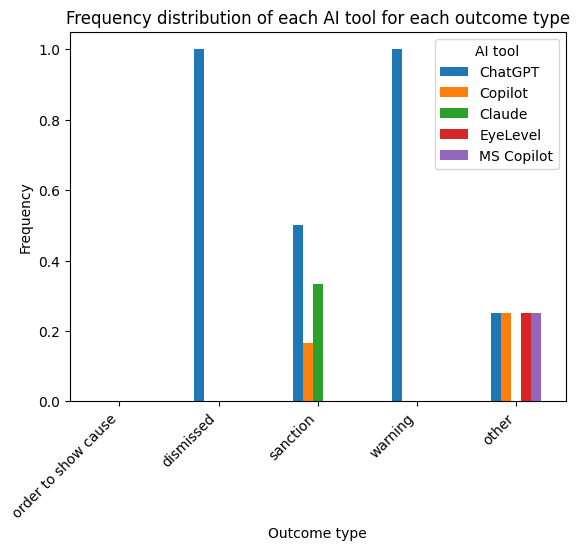

In [53]:
fig, ax = plt.subplots(1,1)
tool_freq_distributions.plot(kind='bar', ax=ax)
ax.set_title('Frequency distribution of each AI tool for each outcome type')
ax.set_xlabel('Outcome type')
ax.set_ylabel('Frequency')
ax.legend(title='AI tool')
plt.xticks(ha='right', rotation=45)
plt.show()

### Results:

Based on the resulting graph, it seems ChatGPT was more frequently associated with dismissed, warning, and sanction than other AI tools, while for 'other' outcomes, the distribution of associated AI tools was uniform. Assuming the data was sufficient, since one AI tool appears to be more frequently associated with an outcome than other, we would likely reject the null hypothesis after performing a statistical analysis.

### Conclusion:

Since the data on AI tools and associated outcomes was highly limited (only 1 row could be sampled for some AI tools), it is difficult to tell if any tool caused their user attorneys  to face an outcome more often than other tools. ChatGPT's prominence in the AI tool frequency distributions for certain outcome types may just be because most samples were based on its use. This project can be improved by doing a further search for data sources with a higher represented of identified AI tools. I can also use statistical analysis to ensure that any tools caused their user attorneys  to face an outcome more often than other tools.